In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

### 1. download the raw data

In [84]:
# import the data
url  = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')

# del data['quality']

# z-score all columns
data = (data - data.mean())/data.std(ddof=1)

### 2. create missing values in the data

In [131]:
nMissing = 10
randomSeed = 123
selected_index = data.sample(10, random_state=randomSeed).index.to_list()

In [132]:
missing_data = data.copy()
print(missing_data.loc[missing_data.index.isin(selected_index), 'residual sugar'])
missing_data.loc[missing_data.index.isin(selected_index), 'residual sugar'] = np.nan

31     -0.027523
263    -0.524002
512    -0.311225
772    -0.169374
912     0.256179
935    -0.169374
1029   -0.524002
1037   -0.524002
1106   -0.453077
1280   -0.453077
Name: residual sugar, dtype: float64


In [134]:
missing_data['residual sugar'].isna().sum()

10

In [133]:
print(data.loc[data.index.isin(selected_index), 'residual sugar'])

31     -0.027523
263    -0.524002
512    -0.311225
772    -0.169374
912     0.256179
935    -0.169374
1029   -0.524002
1037   -0.524002
1106   -0.453077
1280   -0.453077
Name: residual sugar, dtype: float64


### 3. prepare train / test sets

In [135]:
feat_cols = missing_data.columns
feat_cols = feat_cols.drop(['residual sugar'])

X_train = torch.tensor(missing_data[~missing_data.index.isin(selected_index)][feat_cols].values).float()
y_train = torch.tensor(missing_data[~missing_data.index.isin(selected_index)]['residual sugar'].values).float()
y_train = y_train[:,None]

X_test = torch.tensor(data[data.index.isin(selected_index)][feat_cols].values).float()
y_test = torch.tensor(data[data.index.isin(selected_index)]['residual sugar'].values).float()
y_test = y_test[:,None]

In [136]:
train_data = TensorDataset(X_train, y_train)
test_data  = TensorDataset(X_test, y_test)

batchsize = 32

train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [137]:
len(feat_cols)

11

### 4. create model

In [138]:
def createModel(lr=.001):

    class missingValueFFN(nn.Module):

        def __init__(self):
            super().__init__()

            self.input = nn.Linear(len(feat_cols), 16)

            self.fc1 = nn.Linear(16, 64)
            self.fc2 = nn.Linear(64, 32)

            self.output = nn.Linear(32, 1)

        def forward(self, x):

            x = F.relu( self.input(x) )
            x = F.relu( self.fc1(x) )
            x = F.relu( self.fc2(x) )

            return self.output(x)
        
    model = missingValueFFN()

    lossfun = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    return model, lossfun, optimizer

In [139]:
# quick test to see if the model is functioning
model, lossfun, optimizer = createModel(lr=.001)

X,y = next(iter(train_loader))
yHat = model(X)
print(yHat)

lossfun(yHat,y)

tensor([[-0.0669],
        [-0.1063],
        [-0.0675],
        [-0.1127],
        [-0.1106],
        [-0.0755],
        [-0.0360],
        [-0.0680],
        [-0.0601],
        [-0.1032],
        [-0.0488],
        [-0.0410],
        [-0.0782],
        [-0.0816],
        [-0.1074],
        [-0.1023],
        [-0.0425],
        [-0.0411],
        [-0.0763],
        [-0.0654],
        [-0.0374],
        [-0.0619],
        [-0.0946],
        [-0.0662],
        [-0.1040],
        [-0.0897],
        [-0.0522],
        [-0.1017],
        [-0.0782],
        [-0.0475],
        [-0.1049],
        [-0.0790]], grad_fn=<AddmmBackward0>)


tensor(0.6986, grad_fn=<MseLossBackward0>)

### 5. training

In [140]:
def trainModel(numepochs=500):

    # initialize losses and accuracies
    trainLoss = torch.zeros(numepochs)

    # loop through epoch
    for epochi in range(numepochs):

        batchLoss = []

        # loop through minibatch
        for X, y in train_loader:

            # forward pass and loss
            yHat = model(X)
            loss = lossfun(yHat,y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # batch loss
            batchLoss.append(loss.item())
        # end of batch loop

        # train loss
        trainLoss[epochi] = np.mean(batchLoss)

    return trainLoss

In [158]:
model, lossfun, optimizer = createModel(lr=.001)

trainLoss = trainModel(numepochs=100)

### 6. check results

In [159]:
yHat_train = model(X_train)
yHat_test = model(X_test)

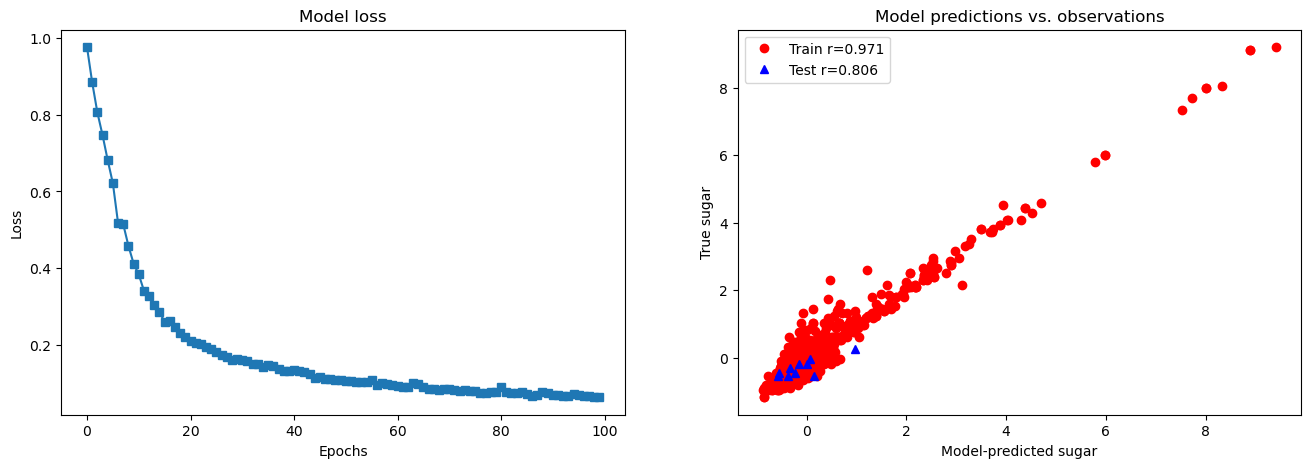

In [160]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(yHat_train.detach(),y_train,'ro')
ax[1].plot(yHat_test.detach(),y_test,'b^')
ax[1].set_xlabel('Model-predicted sugar')
ax[1].set_ylabel('True sugar')
ax[1].set_title('Model predictions vs. observations')

# correlations between predictions and outputs
corrTrain = np.corrcoef(yHat_train.detach().T,y_train.T)[1,0]
corrTest  = np.corrcoef(yHat_test.detach().T, y_test.T)[1,0]
ax[1].legend([ f'Train r={corrTrain:.3f}',f'Test r={corrTest:.3f}' ])

plt.show()